# Trajectory similarity
ref: [link](https://userguide.mdanalysis.org/stable/examples/analysis/trajectory_similarity/README.html)

A molecular dynamics trajectory with N atoms can be considered through a path through 3N-dimensional molecular configuration space. MDAnalysis contains a number of algorithms to compare the conformational ensembles of different trajectories. 

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda

from MDAnalysis.tests.datafiles import (PSF, DCD, DCD2, GRO, XTC,
                                        PSF_NAMD_GBIS, DCD_NAMD_GBIS,
                                        PDB_small, CRD)
from MDAnalysis.analysis import psa


%matplotlib inline
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')

## Comparing the geometric similarity of trajectories

In [2]:
# load the trajectory
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(GRO, XTC)
u4 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)
u5 = mda.Universe(PDB_small, CRD, PDB_small,
                  CRD, PDB_small, CRD, PDB_small)

ref = mda.Universe(PDB_small)


labels = ['DCD', 'DCD2', 'XTC', 'NAMD', 'mixed']
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 10


In [3]:
# aligning trajectories
CORE_sel = 'name CA and (resid 1:29 or resid 60:121 or resid 160:214)'

ps = psa.PSAnalysis([u1, u2, u3, u4, u5],
                    labels=labels,
                    reference=ref,
                    select=CORE_sel,
                    path_select='name CA')

In [4]:
# generating paths
ps.generate_paths(align=True, save=False, weights='mass')

### Hausdorff method
In MDAnalysis, the Hausdorff distance is the RMSD between a pair of conformations in P and Q, where the one of the conformations in the pair has the least similar nearest neighbour.



In [5]:
# We can compute the similarity of each path
# Hausdorff method
ps.run(metric='hausdorff')
ps.D # The distance matrix

array([[ 0.        ,  1.33312648, 22.37206002,  2.04737477,  7.55204678],
       [ 1.33312648,  0.        , 22.3991666 ,  2.07957562,  7.55032598],
       [22.37206002, 22.3991666 ,  0.        , 22.42282661, 25.74534554],
       [ 2.04737477,  2.07957562, 22.42282661,  0.        ,  7.67052252],
       [ 7.55204678,  7.55032598, 25.74534554,  7.67052252,  0.        ]])

<Figure size 640x480 with 0 Axes>

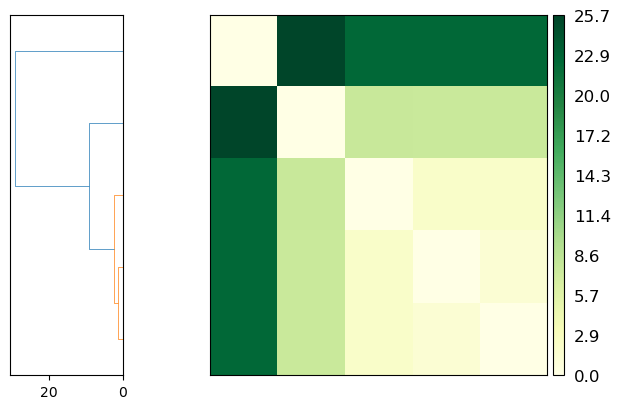

In [6]:
# plotting
fig = ps.plot(linkage='ward')

# psa.PSAnalysis provides two convenience methods for plotting this data. 
# The first is to plot a heat-map dendrogram from clustering the trajectories based on their path similarity. 
# You can use any clustering method supported by scipy.cluster.hierarchy.linkage; the default is ‘ward’.

<Figure size 640x480 with 0 Axes>

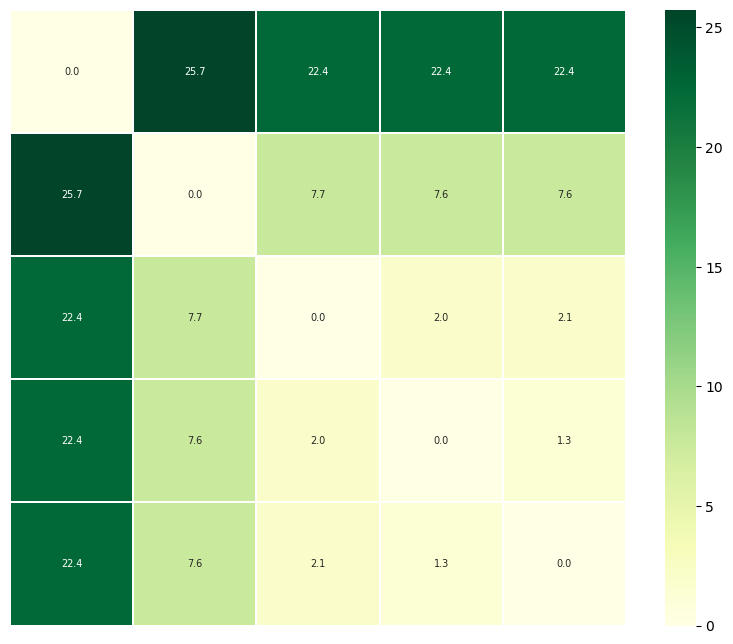

In [7]:
fig = ps.plot_annotated_heatmap(linkage='single')

### Discrete Fréchet distances
In MDAnalysis, the discrete Fréchet distance is the lowest possible RMSD between a conformation from P and a conformation from Q, where the two frames are at similar points along the trajectory, and they are the least structurally similar in that particular coupling sequence.

In [8]:
# Discrete Fréchet distances
ps.run(metric='discrete_frechet')
ps.D

array([[ 0.        ,  1.33312649, 22.37205967,  2.04737475,  7.55204694],
       [ 1.33312649,  0.        , 22.39916723,  2.07957565,  7.55032613],
       [22.37205967, 22.39916723,  0.        , 22.42282569, 25.74534511],
       [ 2.04737475,  2.07957565, 22.42282569,  0.        ,  7.67052241],
       [ 7.55204694,  7.55032613, 25.74534511,  7.67052241,  0.        ]])

<Figure size 640x480 with 0 Axes>

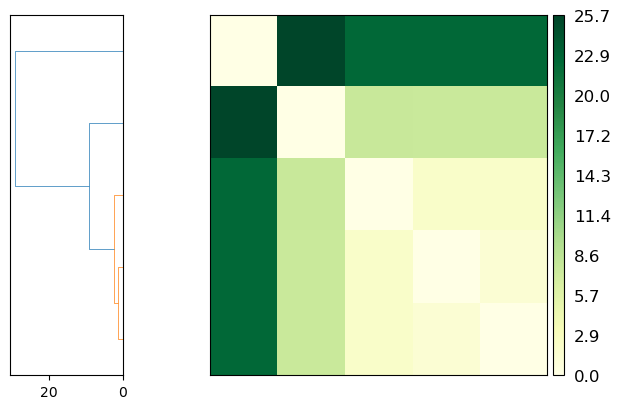

In [9]:
# plotting
fig = ps.plot(linkage='ward')

<Figure size 640x480 with 0 Axes>

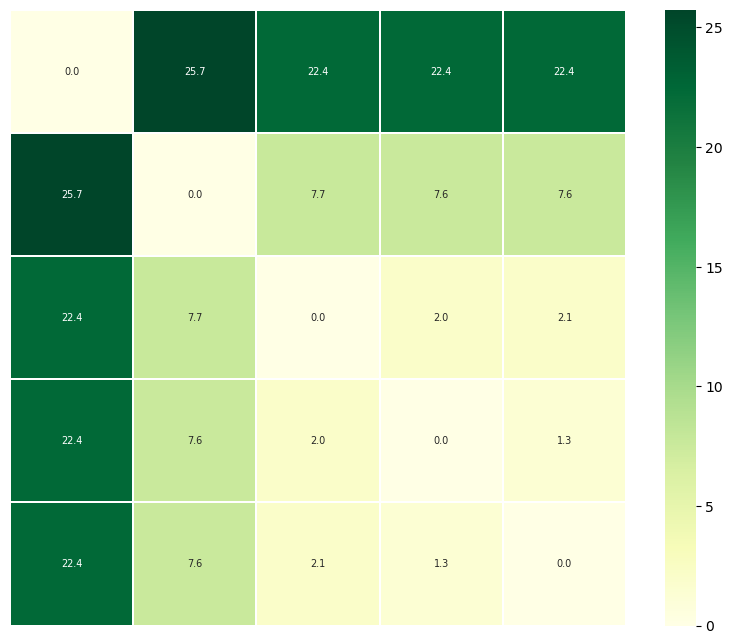

In [10]:
fig = ps.plot_annotated_heatmap(linkage='single')

## Calculating the Harmonic Ensemble Similarity between ensembles
The harmonic ensemble similarity method treats the conformational ensemble within each trajectory as a high-dimensional Gaussian distribution N(μ,Σ). he mean μ is estimated as the average over the ensemble. The covariance matrix Σ is calculated either using a shrinkage estimator (`cov_estimator='shrinkage'`) or a maximum-likelihood method (`cov_estimator='ml'`).

In [11]:
from MDAnalysis.analysis import encore

In [12]:
# load the trajectory
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(GRO, XTC)
u4 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)

labels = ['DCD', 'DCD2', 'XTC', 'NAMD']
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 10


In [13]:
# Calculating harmonic similarity
hes, details = encore.hes([u1, u2, u3, u4],
                         select='backbone',
                         align=True,
                         cov_estimator='shrinkage',
                         weights='mass')

for row in hes:
    for h in row:
        print("{:>10.1f}".format(h), end = ' ')
    print("")

       0.0    24955.7  1879874.5   145622.3 
   24955.7        0.0  1659867.5   161102.3 
 1879874.5  1659867.5        0.0  9900092.7 
  145622.3   161102.3  9900092.7        0.0 


In [14]:
details["ensemble1_mean"].shape

(2565,)

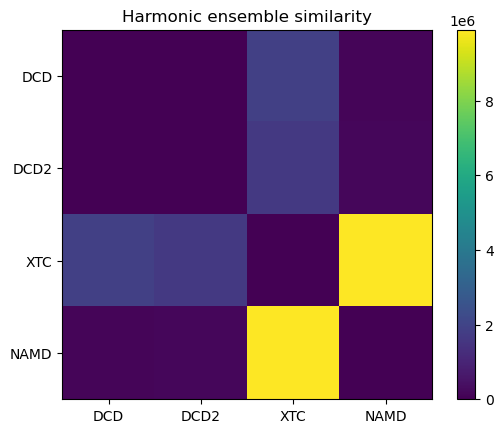

In [15]:
# plotting
fig, ax = plt.subplots()
im = plt.imshow(hes)
plt.xticks(np.arange(4), labels)
plt.yticks(np.arange(4), labels)
plt.title('Harmonic ensemble similarity')
cbar = fig.colorbar(im)

## Calculating the Clustering Ensemble Similarity between ensembles
Here we compare the conformational ensembles of proteins in three trajectories, using the clustering ensemble similarity method.

In [16]:
from MDAnalysis.analysis.encore.clustering import ClusteringMethod as clm

In [17]:
# loading files
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)

labels = ['DCD', 'DCD2', 'NAMD']
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 100


### Calculating clustering similarity with default settings
The clustering ensemble similarity method (`ces`) combines every trajectory into a whole space of conformations, and then uses a user-specified `clustering_method` to partition this into clusters. The population of each trajectory ensemble within each cluster is taken as a probability density function.

The similarity of each probability density function is compared using the Jensen-Shannon divergence. This divergence has an upper bound of ln(2), representing no similarity between the ensembles, and a lower bound of 0.0, representing identical conformational ensembles.

You do not need to align your trajectories, as the function will align it for you (along your `select` atoms, which are `select='name CA'` by default).

In [18]:
ces0, details0 = encore.ces([u1, u2, u3])
print(ces0) # the similarity matrix for the ensemble of trajectories.

[[0.         0.68070702 0.69314718]
 [0.68070702 0.         0.69314718]
 [0.69314718 0.69314718 0.        ]]


In [19]:
cluster_collection = details0['clustering'][0]
print(type(cluster_collection))
print('We have found {} clusters'.format(len(cluster_collection)))

<class 'MDAnalysis.analysis.encore.clustering.ClusterCollection.ClusterCollection'>
We have found 49 clusters


In [20]:
first_cluster = cluster_collection.clusters[0]
print(first_cluster)
print(first_cluster.elements)
print('The ID of this cluster is:', first_cluster.id)
print('The centroid is', first_cluster.centroid)

<Cluster with 5 elements, centroid=1, id=0>
[ 0  1  2  3 98]
The ID of this cluster is: 0
The centroid is 1


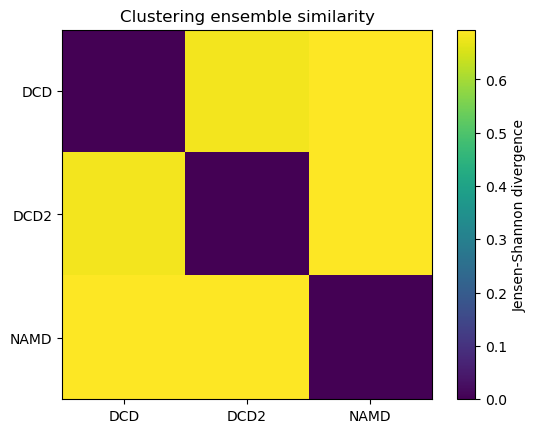

In [21]:
# plotting
fig0, ax0 = plt.subplots()
im0 = plt.imshow(ces0, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Clustering ensemble similarity')
cbar0 = fig0.colorbar(im0)
cbar0.set_label('Jensen-Shannon divergence')

### Calculating clustering simliarity with one method
Clustering methods should be subclasses of `analysis.encore.clustering.ClusteringMethod`, initialised with your chosen parameters. Below, we set up an affinity progragation scheme, which uses message-passing to choose a number of ‘exemplar’ points to represent the data and updates these points until they converge. The `preference` parameter controls how many exemplars are used – a higher value results in more clusters, while a lower value results in fewer clusters. The `damping` factor damps the message passing to avoid numerical oscillations. (See the scikit-learn user guide for more information.)

The other keyword arguments control when to stop clustering. Adding noise to the data can also avoid numerical oscillations.

In [22]:
clustering_method = clm.AffinityPropagationNative(preference=-1.0,
                                                  damping=0.9,
                                                  max_iter=200,
                                                  convergence_iter=30,
                                                  add_noise=True)

In [23]:
ces1, details1 = encore.ces([u1, u2, u3],
                         select='name CA',
                         clustering_method=clustering_method,
                         ncores=4) 
# If it is taking too long and you have the resources, 
# you can increase the number of cores used.

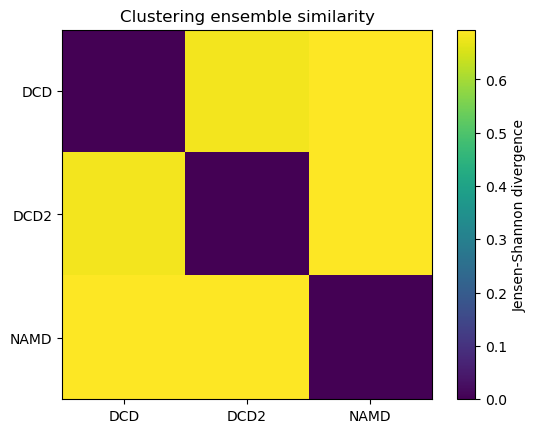

In [24]:
# plotting
fig1, ax1 = plt.subplots()
im1 = plt.imshow(ces1, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Clustering ensemble similarity')
cbar1 = fig1.colorbar(im1)
cbar1.set_label('Jensen-Shannon divergence')

### Calculating clustering similarity with multiple methods
The KMeans clustering algorithm separates samples into `n` groups of equal variance, with centroids that minimise the inertia. You must choose how many clusters to partition.

In [25]:
# Trying out different clustering parameters
km1 = clm.KMeans(12,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km2 = clm.KMeans(6,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

DBSCAN is an algorithm that can identify outliers, or data points that don’t fit into any cluster. `dres()` and `dres_convergence()` treat the outliers as their own cluster. This means that the Jensen-Shannon divergence will be lower than it should be for trajectories that have outliers. Do not use this clustering method unless you are certain that your trajectories will not have outliers.

In [26]:
db1 = clm.DBSCAN(eps=0.5,
                 min_samples=5,
                 algorithm='auto',
                 leaf_size=30)

db2 = clm.DBSCAN(eps=1,
                 min_samples=5,
                 algorithm='auto',
                 leaf_size=30)

When we pass a list of clustering methods to `encore.ces`, the results get saved in ces2 and details2 in order.

In [27]:
ces2, details2 = encore.ces([u1, u2, u3],
                         select='name CA',
                         clustering_method=[km1, km2, db1, db2],
                         ncores=4)
print(len(ces2), len(details2['clustering']))

4 4


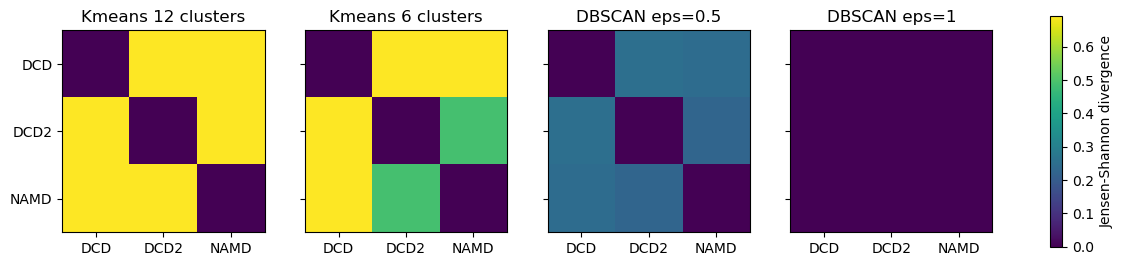

In [28]:
# plotting 
titles = ['Kmeans 12 clusters', 'Kmeans 6 clusters', 'DBSCAN eps=0.5', 'DBSCAN eps=1']
fig2, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
for i, (data, title) in enumerate(zip(ces2, titles)):
    imi = axes[i].imshow(data, vmax=np.log(2), vmin=0)
    axes[i].set_xticks(np.arange(3))
    axes[i].set_xticklabels(labels)
    axes[i].set_title(title)
plt.yticks(np.arange(3), labels)
cbar2 = fig2.colorbar(imi, ax=axes.ravel().tolist())
cbar2.set_label('Jensen-Shannon divergence')

# As can be seen, reducing the number of clusters 
# in the K-means method emphasises that DCD2 is 
# more similar to the NAMD trajectory than DCD. 
# Meanwhile, increasing eps in DBSCAN clearly 
# lowered the density required to form a cluster 
# so much that every trajectory is in the same cluster, and 
# therefore they have identical probability distributions.

In [29]:
n_db = len(details2['clustering'][-1])

print('Number of clusters in DBSCAN eps=1: {}'.format(n_db))

Number of clusters in DBSCAN eps=1: 1


### Estimating the error in a clustering ensemble similarity
`encore.ces` also allows for error estimation using a bootstrapping method. This returns the average Jensen-Shannon divergence, and standard deviation over the samples.

In [30]:
avgs, stds = encore.ces([u1, u2, u3],
                         select='name CA',
                         clustering_method=clustering_method,
                         estimate_error=True,
                         ncores=4)
print("avgs: \n", avgs)
print("stds: \n", stds)

avgs: 
 [[0.         0.68329648 0.69314718]
 [0.68329648 0.         0.68748219]
 [0.69314718 0.68748219 0.        ]]
stds: 
 [[0.00000000e+00 5.02574442e-03 7.02166694e-17]
 [5.02574442e-03 0.00000000e+00 6.93816282e-03]
 [7.02166694e-17 6.93816282e-03 0.00000000e+00]]


## Calculating the Dimension Reduction Ensemble Similarity between ensembles
Here we compare the conformational ensembles of proteins in four trajectories, using the dimension reduction ensemble similarity method.

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from MDAnalysis.analysis.encore.dimensionality_reduction import DimensionalityReductionMethod as drm

In [32]:
# loading files
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)

labels = ['DCD', 'DCD2', 'NAMD']
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 100


### Calculating dimension reduction similarity with default settings
The dimension reduction similarity method projects ensembles onto a lower-dimensional space using your chosen dimension reduction algorithm (by default: stochastic proximity embedding). A probability density function is estimated with Gaussian-based kernel-density estimation, using Scott’s rule to select the bandwidth.

The similarity of each probability density function is compared using the Jensen-Shannon divergence. This divergence has an upper bound of ln(2) and a lower bound of 0.0. Normally, ln(2) represents no similarity between the ensembles, and 0.0 represents identical conformational ensembles. However, due to the stochastic nature of the dimension reduction, two identical symbols will not necessarily result in an exact divergence of 0.0. In addition, calculating the similarity with `dres()` twice will result in similar but not identical numbers.

You do not need to align your trajectories, as the function will align it for you (along your selection atoms, which are `select='name CA'` by default). The function we use is `dres`.

In [33]:
dres0, details0 = encore.dres([u1, u2, u3])

In [34]:
dres0

array([[0.        , 0.68813106, 0.68972359],
       [0.68813106, 0.        , 0.66493138],
       [0.68972359, 0.66493138, 0.        ]])

In [35]:
reduced = details0['reduced_coordinates'][0]
reduced.shape

(3, 300)

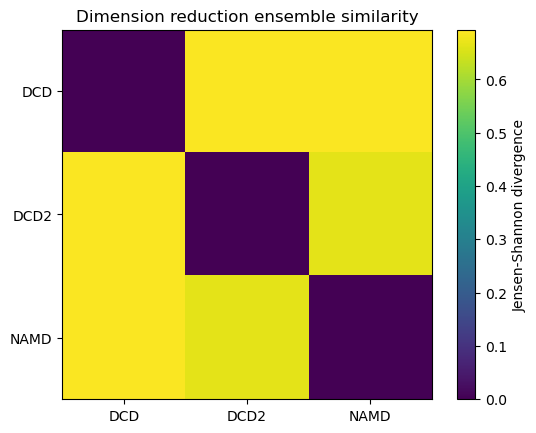

In [36]:
# plotting
fig0, ax0 = plt.subplots()
im0 = plt.imshow(dres0, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Dimension reduction ensemble similarity')
cbar0 = fig0.colorbar(im0)
cbar0.set_label('Jensen-Shannon divergence')

In [37]:
# a helper function to make it easier to partition the data
def zip_data_with_labels(reduced):
    rd_dcd = reduced[:, :98]  # first 98 frames
    rd_dcd2 = reduced[:, 98:(98+102)]  # next 102 frames
    rd_namd = reduced[:,(98+102):]  # last 100 frames
    return zip([rd_dcd, rd_dcd2, rd_namd], labels)

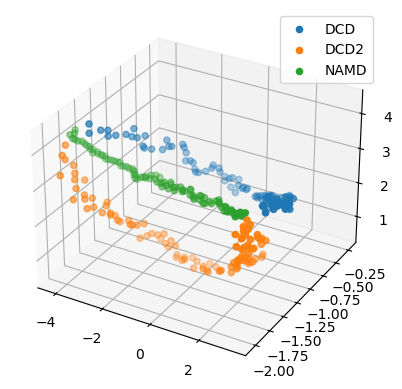

In [38]:
rdfig0 = plt.figure()
rdax0 = rdfig0.add_subplot(111, projection='3d')
for data, label in zip_data_with_labels(reduced):
    rdax0.scatter(*data, label=label)
plt.legend()

### Calculating dimension reduction similarity with one method
Dimension reduction methods should be subclasses of `analysis.encore.dimensionality_reduction.DimensionalityReductionMethod`, initialised with your chosen parameters.

Below, we set up stochastic proximity embedding scheme, which maps data to lower dimensions by iteratively adjusting the distance between a pair of points on the lower-dimensional map to match their full-dimensional proximity. The learning rate controls the magnitude of these adjustments, and decreases over the mapping from `max_lam` (default: 2.0) to `min_lam` (default: 0.1) to avoid numerical oscillation. The learning rate is updated every cycle for `ncycle`s, over which `nstep` adjustments are performed.

The number of dimensions to map to is controlled by the keyword `dimension` (default: 2).

In [39]:
dim_red_method = drm.StochasticProximityEmbeddingNative(dimension=3,
                                                        min_lam=0.2,
                                                        max_lam=1.0,
                                                        ncycle=50,
                                                        nstep=1000)

In [40]:
dres1, details1 = encore.dres([u1, u2, u3],
                         select='name CA',
                         dimensionality_reduction_method=dim_red_method,
                         nsamples=1000,
                         ncores=4)

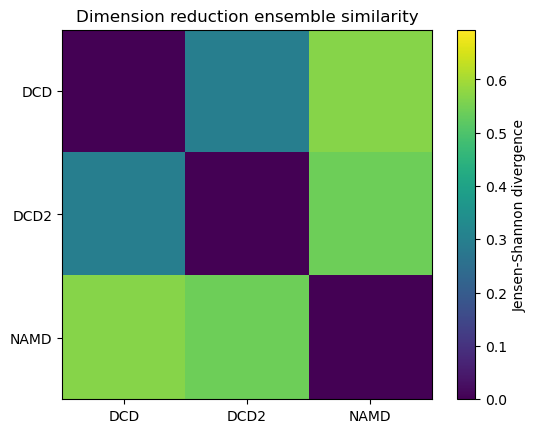

In [41]:
# plotting
fig1, ax1 = plt.subplots()
im1 = plt.imshow(dres1, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Dimension reduction ensemble similarity')
cbar1 = fig1.colorbar(im1)
cbar1.set_label('Jensen-Shannon divergence')

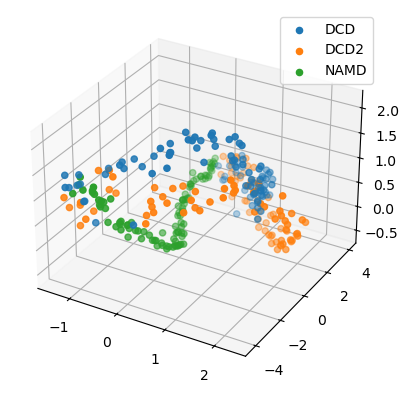

In [42]:
reduced1 = details1['reduced_coordinates'][0]

rdfig1 = plt.figure()
rdax1 = rdfig1.add_subplot(111, projection='3d')
for data, label in zip_data_with_labels(reduced1):
    rdax1.scatter(*data, label=label)
plt.legend()

### Calculating dimension reduction similarity with multiple methods
You may want to try different dimension reduction methods, or use different parameters within the methods. `encore.dres` allows you to pass a list of `dimensionality_reduction_methods` to be applied.

In [43]:
# trying out different dimension reduction parameters
pc1 = drm.PrincipalComponentAnalysis(dimension=1,
                                     svd_solver='auto')
pc2 = drm.PrincipalComponentAnalysis(dimension=2,
                                     svd_solver='auto')
pc3 = drm.PrincipalComponentAnalysis(dimension=3,
                                     svd_solver='auto')
pc4 = drm.PrincipalComponentAnalysis(dimension=4,
                                     svd_solver='auto')

In [44]:
dres2, details2 = encore.dres([u1, u2, u3],
                         select='name CA',
                         dimensionality_reduction_method=[pc1, pc2, pc3, pc4],
                         ncores=4)
print(len(dres2), len(details2['reduced_coordinates']))

4 4


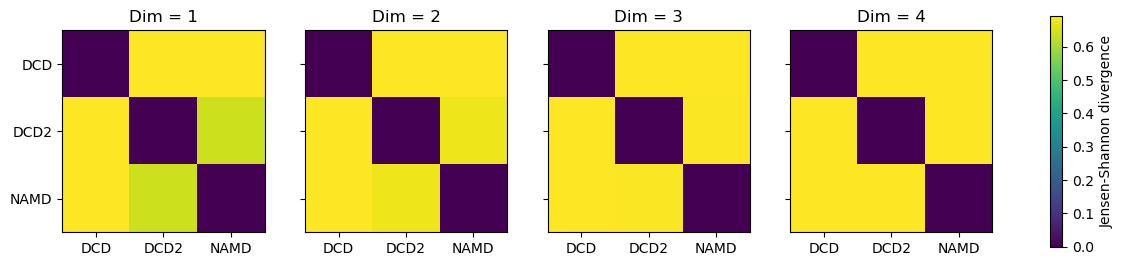

In [45]:
# plotting
titles = ['Dim = {}'.format(n) for n in range(1, 5)]
fig2, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
for i, (data, title) in enumerate(zip(dres2, titles)):
    imi = axes[i].imshow(data, vmax=np.log(2), vmin=0)
    axes[i].set_xticks(np.arange(3))
    axes[i].set_xticklabels(labels)
    axes[i].set_title(title)
plt.yticks(np.arange(3), labels)
cbar2 = fig2.colorbar(imi, ax=axes.ravel().tolist())
cbar2.set_label('Jensen-Shannon divergence')

# In this case, adding more dimensions to the 
# principal component analysis has little difference 
# in how similar each ensemble is over its resulting 
# probability distribution (i.e. not similar at all!)

[Text(1, 0, 'DCD'), Text(2, 0, 'DCD2'), Text(3, 0, 'NAMD')]

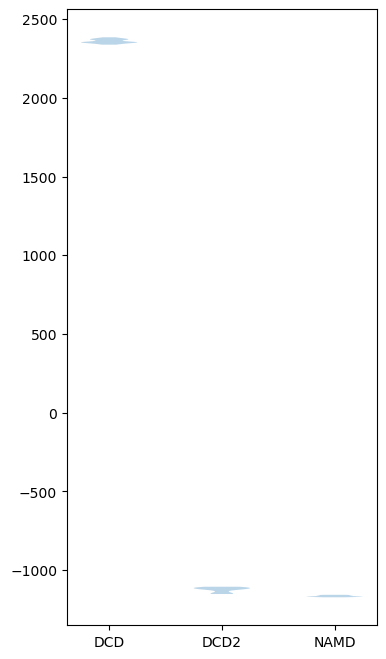

In [46]:
# violin plots
rd_p1, rd_p2, rd_p3, _ = details2['reduced_coordinates']

d_p1_fig, rd_p1_ax = plt.subplots(figsize=(4, 8))
split_data = [x[0].reshape((-1,)) for x in zip_data_with_labels(rd_p1)]
rd_p1_ax.violinplot(split_data, showextrema=False)
rd_p1_ax.set_xticks(np.arange(1, 4))
rd_p1_ax.set_xticklabels(labels)

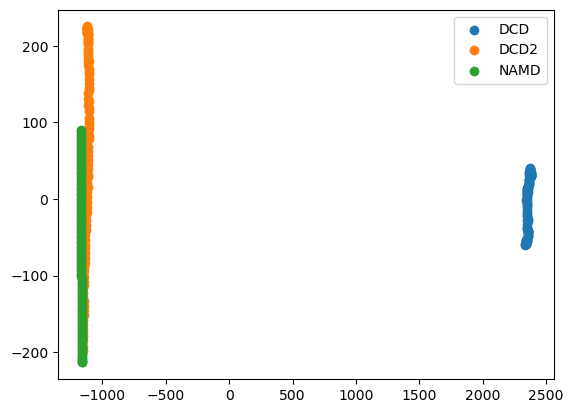

In [47]:
# second component
rd_p2_fig, rd_p2_ax = plt.subplots()
for data, label in zip_data_with_labels(rd_p2):
    rd_p2_ax.scatter(*data, label=label)
plt.legend()

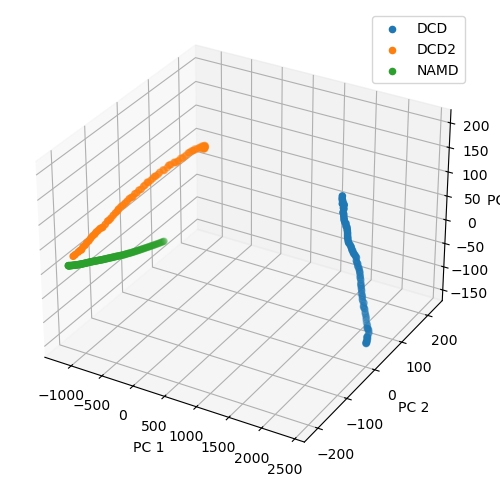

In [48]:
# top three components
rd_p3_fig = plt.figure(figsize=(8, 6))
rd_p3_ax = rd_p3_fig.add_subplot(111, projection='3d')
for data, label in zip_data_with_labels(rd_p3):
    rd_p3_ax.scatter(*data, label=label)
rd_p3_ax.set_xlabel('PC 1')
rd_p3_ax.set_ylabel('PC 2')
rd_p3_ax.set_zlabel('PC 3')
plt.legend()

### Estimating the error in a dimension reduction ensemble similarity analysis
`encore.dres` also allows for error estimation using a bootstrapping method. This returns the average Jensen-Shannon divergence, and standard deviation over the samples.

In [49]:
avgs, stds = encore.dres([u1, u2, u3],
                         select='name CA',
                         dimensionality_reduction_method=dim_red_method,
                         estimate_error=True,
                         ncores=4)
print("avgs: \n", avgs)
print("stds: \n", stds)

avgs: 
 [[0.         0.24092055 0.59206865]
 [0.24092055 0.         0.59447638]
 [0.59206865 0.59447638 0.        ]]
stds: 
 [[0.         0.06429118 0.04405975]
 [0.06429118 0.         0.04123481]
 [0.04405975 0.04123481 0.        ]]


## Evaluating convergence
Here we evaluate the convergence of a trajectory using the clustering ensemble similarity method and the dimensionality reduction ensemble similarity methods.

The convergence of the trajectory is evaluated by the similarity of the conformation ensembles in windows of the trajectory. The trajectory is divided into windows that increase by window_size frames. 

In [50]:
# loading files
u = mda.Universe(PSF, DCD)

### Using default arguments with clustering ensemble similarity


In [51]:
ces_conv = encore.ces_convergence(u,  # universe
                                  10,  # window size
                                  select='name CA')  # default

# output: (number_of_windows, number_of_clustering_methods).

In [52]:
for row in ces_conv:
    for sim in row:
        print("{:>7.4f}".format(sim))

 0.4819
 0.4028
 0.3170
 0.2522
 0.1983
 0.1464
 0.0991
 0.0567
 0.0000


Text(0, 0.5, 'Jensen-Shannon divergence')

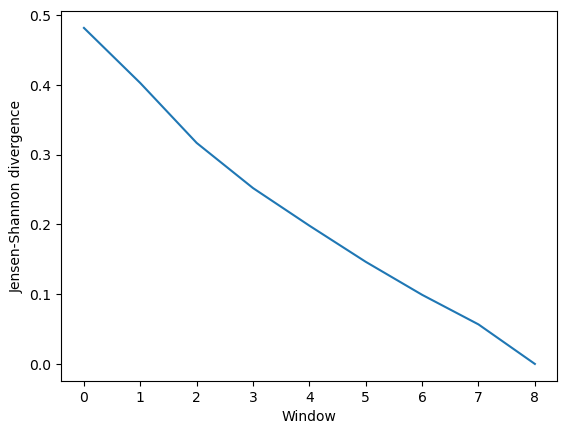

In [53]:
ces_fig, ces_ax = plt.subplots()
plt.plot(ces_conv)
ces_ax.set_xlabel('Window')
ces_ax.set_ylabel('Jensen-Shannon divergence')

### Comparing different clustering methods
You may want to try different clustering methods, or use different parameters within the methods. `encore.ces_convergence` allows you to pass a list of clustering_methods to be applied.

The KMeans clustering algorithm separates samples into n groups of equal variance, with centroids that minimise the inertia.

In [54]:
km1 = clm.KMeans(12,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km2 = clm.KMeans(6,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km3 = clm.KMeans(3,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

In [55]:
ces_conv2 = encore.ces_convergence(u,  # universe
                                  10,  # window size
                                  select='name CA',
                                  clustering_method=[km1, km2, km3]
                                 )
ces_conv2.shape

(9, 3)

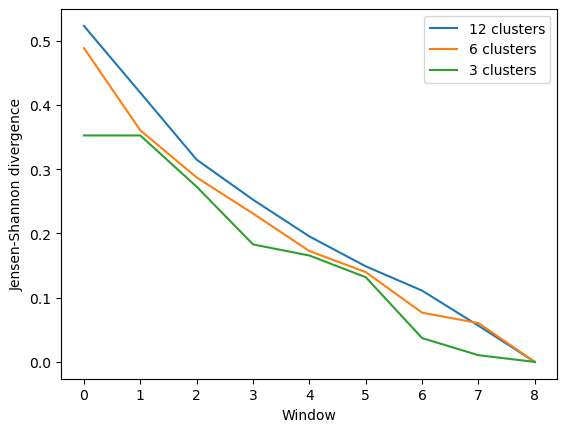

In [56]:
labels = ['12 clusters', '6 clusters', '3 clusters']

ces_fig2, ces_ax2 = plt.subplots()
for data, label in zip(ces_conv2.T, labels):
    plt.plot(data, label=label)
ces_ax2.set_xlabel('Window')
ces_ax2.set_ylabel('Jensen-Shannon divergence')
plt.legend()

### Using default arguments with dimension reduction ensemble similarity

In [57]:
dres_conv = encore.dres_convergence(u,  # universe
                                  10,  # window size
                                  select='name CA')  # default

# the output is an array of similarity values

In [58]:
dres_conv

array([[0.56144788],
       [0.42469169],
       [0.32857343],
       [0.26066367],
       [0.19367071],
       [0.12986255],
       [0.0697173 ],
       [0.04416763],
       [0.        ]])

Text(0, 0.5, 'Jensen-Shannon divergence')

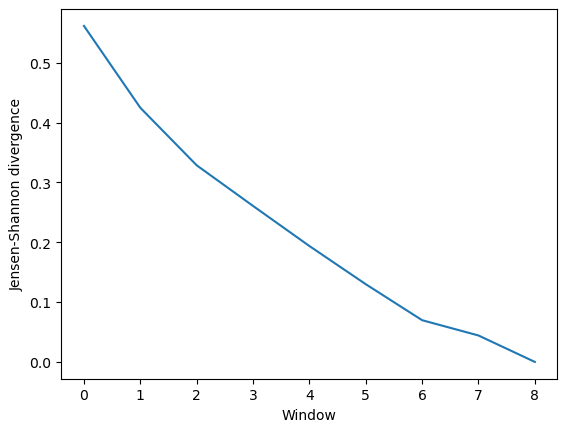

In [59]:
dres_fig, dres_ax = plt.subplots()
plt.plot(dres_conv)
dres_ax.set_xlabel('Window')
dres_ax.set_ylabel('Jensen-Shannon divergence')

### Comparing different dimensionality reduction methods

In [60]:
pc1 = drm.PrincipalComponentAnalysis(dimension=1,
                                     svd_solver='auto')
pc2 = drm.PrincipalComponentAnalysis(dimension=2,
                                     svd_solver='auto')
pc3 = drm.PrincipalComponentAnalysis(dimension=3,
                                     svd_solver='auto')

In [61]:
dres_conv2 = encore.dres_convergence(u,  # universe
                                  10,  # window size
                                  select='name CA',
                                  dimensionality_reduction_method=[pc1, pc2, pc3]
                                 )
dres_conv2.shape

(9, 3)

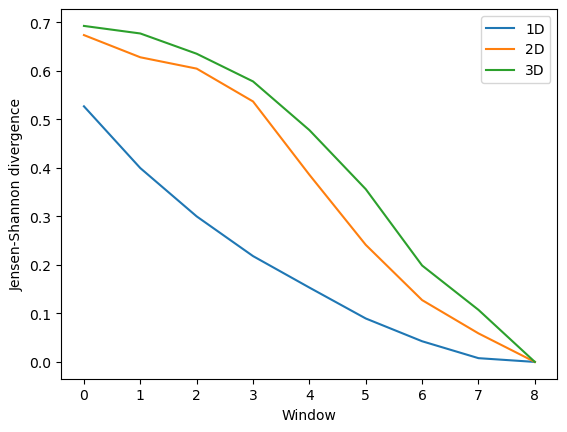

In [62]:
labels = ['1D', '2D', '3D']

dres_fig2, dres_ax2 = plt.subplots()
for data, label in zip(dres_conv2.T, labels):
    plt.plot(data, label=label)
dres_ax2.set_xlabel('Window')
dres_ax2.set_ylabel('Jensen-Shannon divergence')
plt.legend()